In [1]:
import re

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson

import seaborn as sns
import matplotlib.pyplot as plt
import folium

%matplotlib inline

pd.set_option('display.max_rows', 1000)

## VISUALIZE ARTURO MODEL (Already cleaned)

El modelo de arturo.300000kms.net está dividido en dos JSON:
>- datos de entrenamiento en json con columnas value y dm_id
>- modelo de datos urbanísticos en geojson

In [2]:
arturo_path = '../data/raw/arturo' # arturo_modelo.json & model.geojson

with open(f"{arturo_path}/arturo_modelo.json") as f:
    arturo_json = geojson.load(f)
    # list of dict with keys: value and dm_id
    
urban_df = gpd.read_file(f"{arturo_path}/model.geojson")

EDA de datos de entrenamiento

In [3]:
arturo_json_pd = pd.DataFrame(arturo_json)

display(arturo_json_pd.head(10).T)
display(arturo_json_pd.info())

print(f"Unique values in value col: \t {arturo_json_pd['value'].nunique()*100/arturo_json_pd['value'].size}")
print(f"Unique values in dm_id col: \t {arturo_json_pd['dm_id'].nunique()*100/arturo_json_pd['dm_id'].size}")

# en ambas columnas sólo hay valores únicos
# dm_id es la col que conecta con el geojson
# value es el valor de calidad votado por los ciudadanos

,0,1,2,3,4,5,6,7,8,9
value,21.0104,20.2034,15.743,17.2082,15.0262,21.5883,16.4932,23.359,27.0116,25.6708
dm_id,1001,10015,10069,10070,10072,10075,10087,10093,10102,10105


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   5465 non-null   float64
 1   dm_id   5465 non-null   object 
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


None

Unique values in value col: 	 100.0
Unique values in dm_id col: 	 100.0


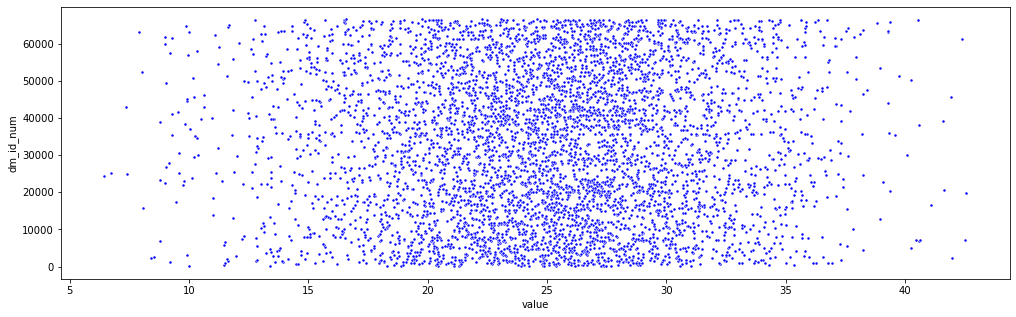

Range in value col: 	 [6.447847761767921,  42.57460885029834]
Range in dm_id col: 	 [25,  66506]


In [4]:
arturo_json_pd['dm_id_num'] = pd.to_numeric(arturo_json_pd['dm_id'], downcast = 'integer')

fig, ax = plt.subplots(figsize = (17,5))
sns.scatterplot(data = arturo_json_pd[0:100000], x = 'value', y = 'dm_id_num', 
                marker = ".", color ="b", ax = ax)
plt.show()

print(f"Range in value col: \t [{arturo_json_pd['value'].min()},  {arturo_json_pd['value'].max()}]")
print(f"Range in dm_id col: \t [{arturo_json_pd['dm_id_num'].min()},  {arturo_json_pd['dm_id_num'].max()}]")
# valores dm_id y value no están georeferenciados 

Los datos de geojson son un conjunto de indicadores empleados para entrenar el modelo de Arturo, geolocalizados a través del viario de Madrid (se desconoce el año del callejero 2019 ó 2019) y la col dm_id

In [5]:
## añadir columna de valoraciones de la calidad del esp publico en df
arturo_sorted = arturo_json_pd.set_index('dm_id').sort_values(by = 'dm_id')
urban_df = urban_df.join(arturo_sorted, on = 'dm_id')

display(urban_df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66499 entries, 0 to 66498
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OGC_FID                        66499 non-null  object  
 1   geom_pu                        66499 non-null  object  
 2   dist_barri                     66483 non-null  object  
 3   dm_id                          66499 non-null  object  
 4   train                          66499 non-null  int64   
 5   land_use_mix                   66499 non-null  float64 
 6   closeness_small_parks          66499 non-null  float64 
 7   residence_ratio                66499 non-null  float64 
 8   block_area                     66499 non-null  float64 
 9   intersection_density           66499 non-null  float64 
 10  anisotropicity                 66499 non-null  float64 
 11  average_age                    66499 non-null  float64 
 12  age_diversity           

None

In [6]:
# vistazo a columnas que no sé qué son
display(urban_df[['OGC_FID', 'geom_pu', 'dist_barri', 'dm_id', 'average_quality', 'pk', 'geometry']].head())

# OGC_FID y pk son indexes
display(urban_df[['OGC_FID', 'dm_id', 'pk']].tail(19).T)

,OGC_FID,geom_pu,dist_barri,dm_id,average_quality,pk,geometry
0,1,SRID=25830;POINT(444133.736820226 4482808.8916...,1606,1,3.277406,1,"MULTILINESTRING ((-3.65969 40.49369, -3.65882 ..."
1,2,SRID=25830;POINT(444192.038205298 4482878.0294...,1606,2,3.113298,2,"MULTILINESTRING ((-3.65833 40.49494, -3.65848 ..."
2,3,SRID=25830;POINT(444134.537506681 4482885.3751...,1606,3,3.143822,3,"MULTILINESTRING ((-3.65969 40.49506, -3.65882 ..."
3,4,SRID=25830;POINT(445612.690578458 4479335.7195...,1603,4,5.740980,4,"MULTILINESTRING ((-3.64155 40.46301, -3.64146 ..."
4,5,SRID=25830;POINT(445606.319326282 4479354.4426...,1603,5,5.468163,5,"MULTILINESTRING ((-3.64161 40.46315, -3.64155 ..."


,66480,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498
OGC_FID,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498,66499
dm_id,66505,66506,66507,66508,66509,66510,66511,66512,66513,66514,66515,66516,66517,66518,66519,66520,66521,66522,66523
pk,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498,66499


### NEW DF WITH GEOMETRIES OF POINTS

In [7]:
urban_df.drop(['geometry'], axis = 1, inplace = True)

urban_df['geom_point'] = urban_df.apply(lambda x: x['geom_pu'].split(';')[1], axis = 1)
urban_df['point_list'] = urban_df.apply(lambda x: re.findall(r'\d+', x['geom_point']), axis = 1)

urban_df['point_x'] = urban_df.apply(lambda x: float(str(x['point_list'][0]) +'.'+ str(x['point_list'][1])), axis = 1)
urban_df['point_y'] = urban_df.apply(lambda x: float(str(x['point_list'][2]) +'.'+ str(x['point_list'][3])), axis = 1)

In [8]:
urban_point_df = gpd.GeoDataFrame(
        urban_df, geometry = gpd.points_from_xy(urban_df['point_x'], urban_df['point_y']))

In [9]:
urban_point_df.drop(['point_list', 'geom_point', 'point_x', 'point_y', 'geom_pu'], axis = 1, inplace = True)

In [15]:
# FIRST DISPLAY OF NANs
display(urban_point_df.shape[0])
display(urban_point_df['value'].isna().sum())
display(urban_point_df['value'].notnull().sum())
print(f"Percentage of Nulls: {urban_point_df['value'].isna().sum()*100 / urban_point_df.shape[0]}")

66499

61034

5465

Percentage of Nulls: 91.78183130573392


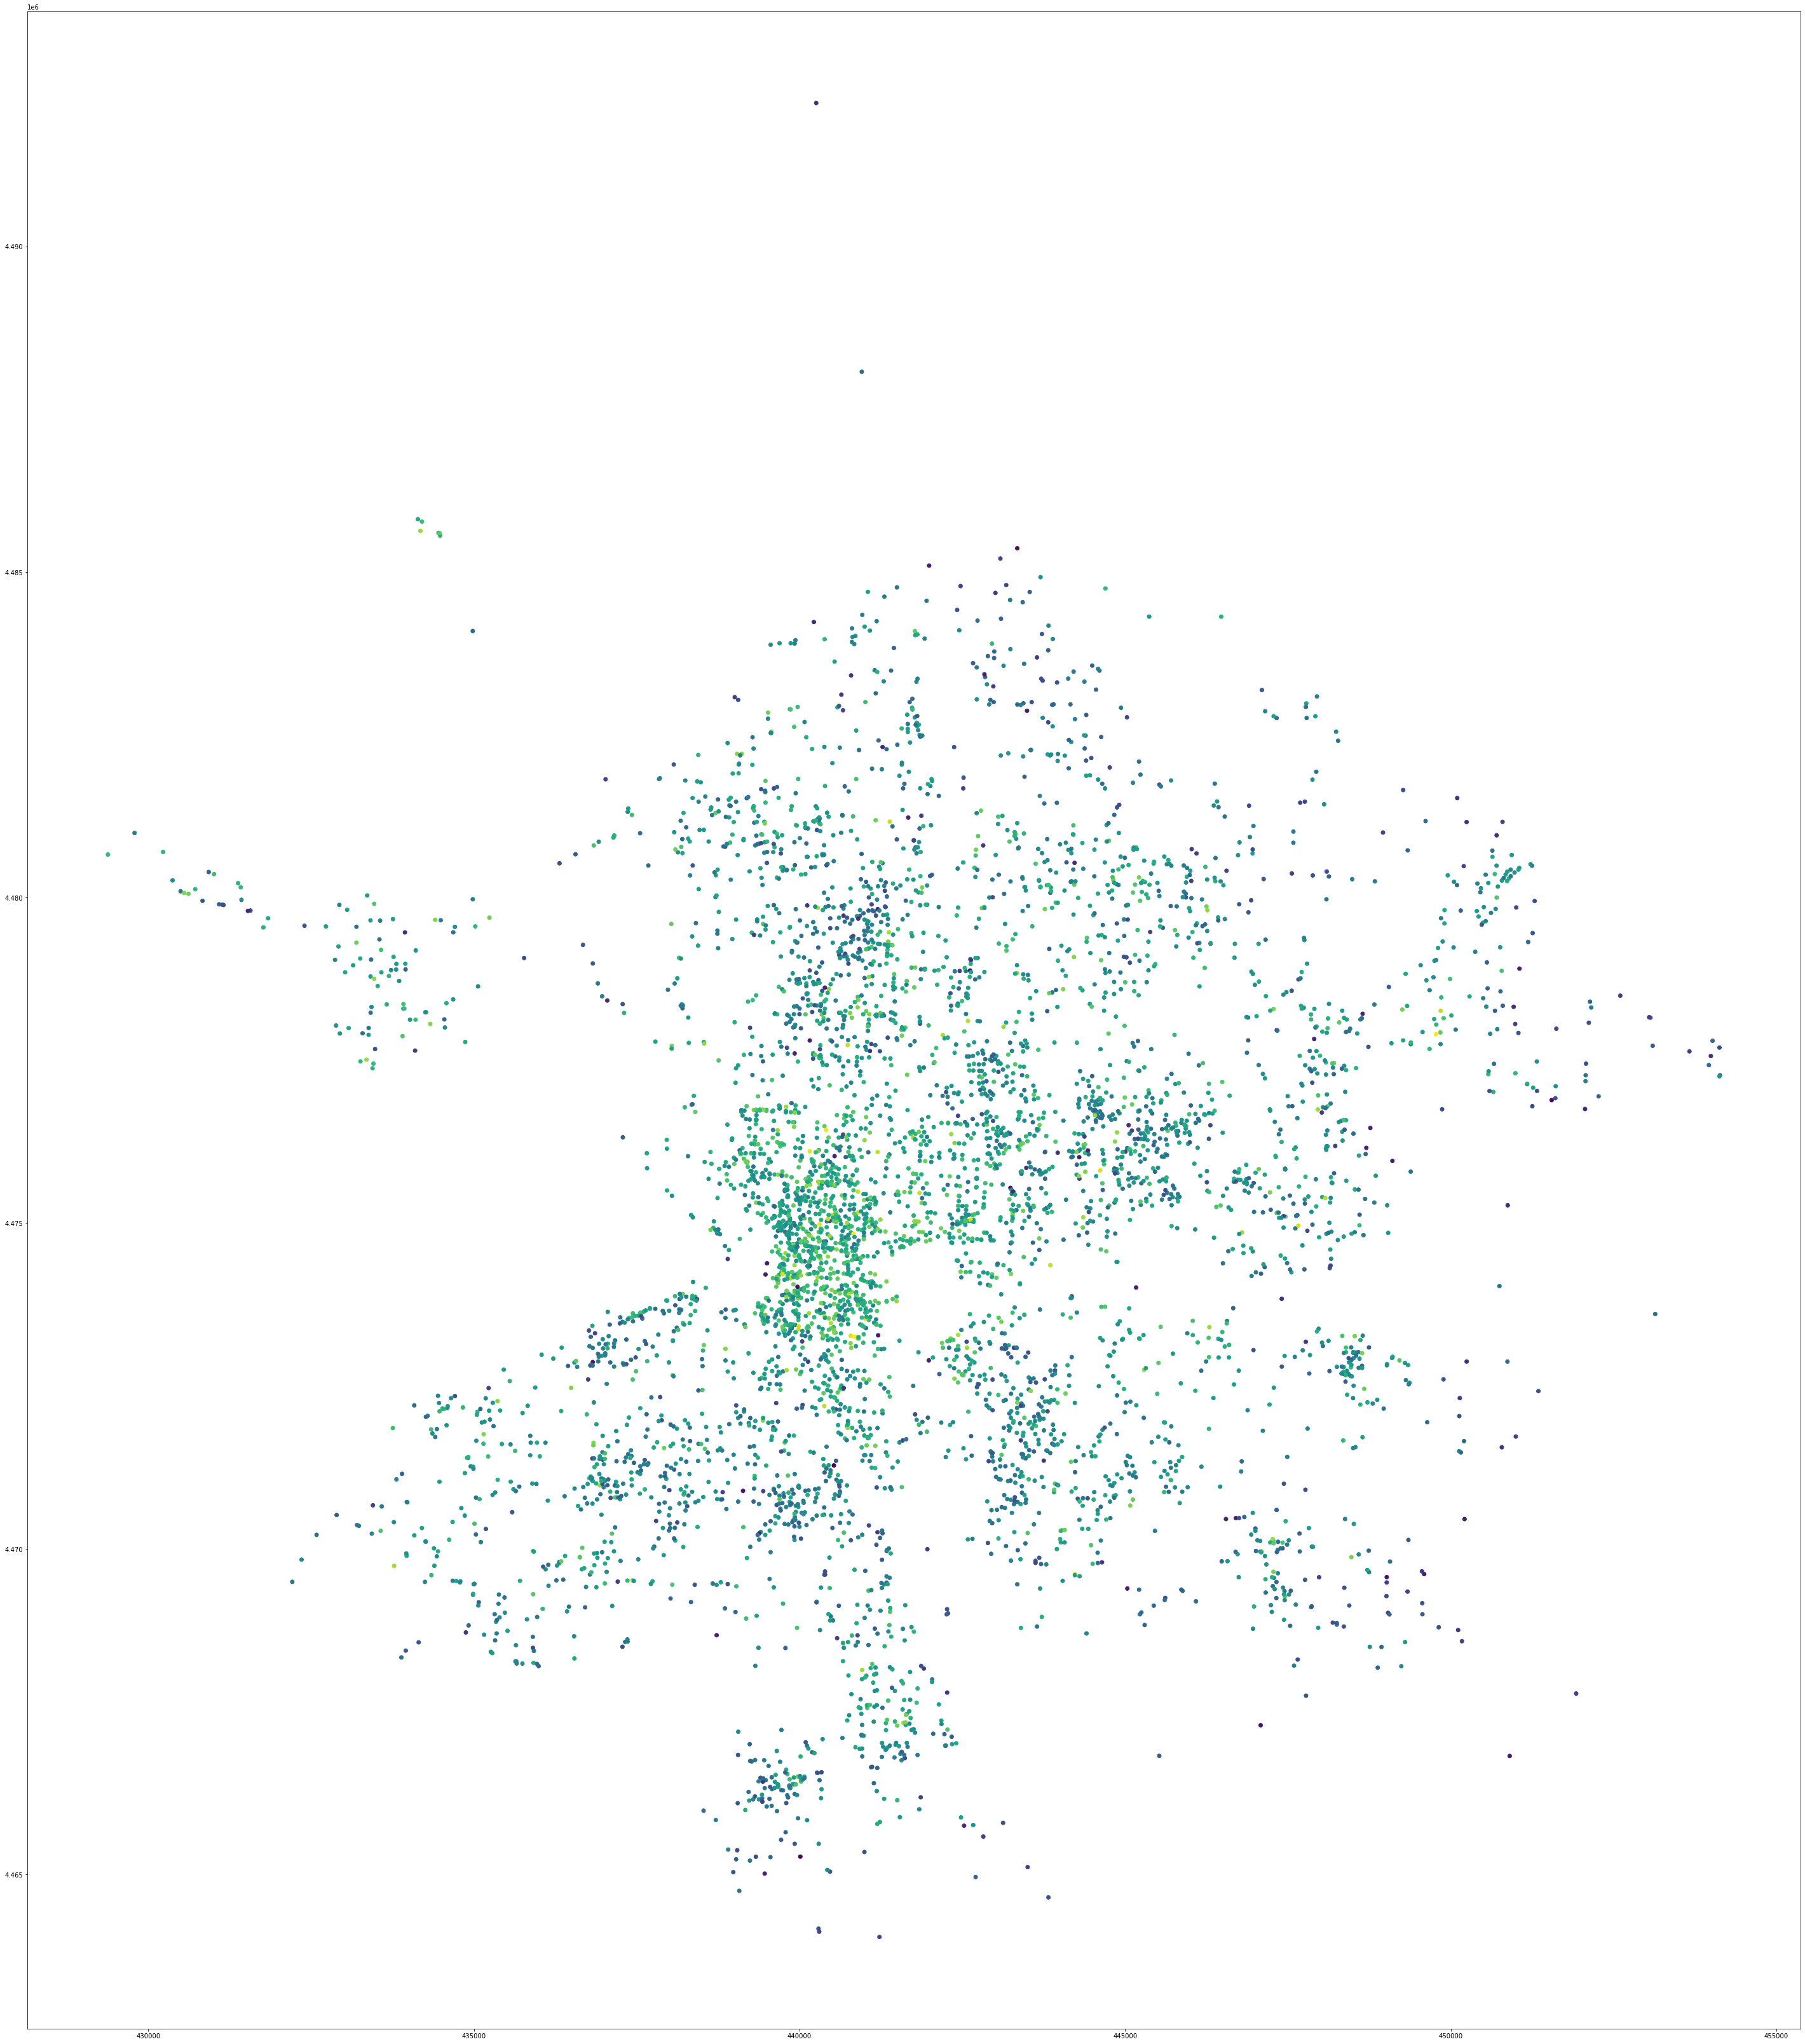

In [14]:
# DRAWING
col_to_draw = 'value'
urban_point_df[urban_point_df.value.notnull()][['geometry', col_to_draw]].plot(figsize = (50,75), column = col_to_draw, legend = False)
plt.show()

In [12]:
urban_point_df[['dm_id', 'dist_barri', 'value', 'dm_id_num', 'geometry']].isna().sum() 
# solo muestro estas columnas al haber un porrón y sólo haber nulls en algunas de estas

dm_id             0
dist_barri       16
value         61034
dm_id_num     61034
geometry          0
dtype: int64

### MERGING STUFF

In [ ]:
def change_value(x):
    
    if np.isnan(x['value']): 
        return x['value_right']
    else: 
        return x['value']
    
def value_propagation(gdf, cols, geometry_col, value_col, buffer_res, dist_to_propagate):
    """
    given a gdf with loads of NaNs, propagate mean values from not-nulls
    
    gdf = urban_point_df,
    cols = ['dm_id', 'value'],
    geometry_col = 'geometry',
    value_col = 'value',
    buffer_res = 35,
    dist_to_propagate = 25
    """
    # variables
    filtr = urban_point_df[value_col].notnull()

    # Making Offset
    gdf['buffer_geom'] = gdf[geometry_col][filtr].buffer(distance = dist_to_propagate, 
                                                       resolution = buffer_res)
    # Making GeoDF
    cols_buffer = cols + ['buffer_geom']
    aux_gdf = gpd.GeoDataFrame(gdf[cols_buffer][filtr],
                    geometry = gdf['buffer_geom'][filtr])

    # Spacial Union 
    cols_geom = cols + [geometry_col]
    points_gdf = gpd.sjoin(gdf[cols_geom][~filtr], 
                           aux_gdf, 
                           how='inner', 
                           op='within')
 
    points_gdf.groupby(by = ['buffer_geom'], dropna = True)
    points_gdf = points_gdf[['dm_id_left', 'value_right']]
    points_gdf = points_gdf.groupby(by = ['dm_id_left']).mean().sort_index().reset_index()

    ## Merging and cleaning the mess
    gdf = gdf.merge(points_gdf, how = 'left', left_on = 'dm_id', right_on = 'dm_id_left')
    gdf[value_col] = gdf.apply(change_value, axis = 1)
    gdf.drop(['buffer_geom', 'dm_id_left', 'value_right'], axis = True, inplace = True)
    
    return gdf


def repeat_value_propagation(dist_list, gdf):
    loop_gdf = gdf
    for i, d in enumerate(dist_list):
        final_gdf = value_propagation(gdf = loop_gdf,
                                      cols = ['dm_id', 'value'],
                                      geometry_col = 'geometry',
                                      value_col = 'value',
                                      buffer_res = 30,
                                      dist_to_propagate = dist_list[i])
        loop_gdf = final_gdf
    return final_gdf



In [ ]:
urban_point_df = repeat_value_propagation(dist_list = [30, 70, 50, 40, 25, 15],
                                          gdf = urban_point_df)

In [ ]:
# SECOND DISPLAY OF NANS
print(f"Shape: \t\t\t\t{urban_point_df.shape[0]}")
print(f"Remaining nulls : \t\t{urban_point_df['value'].isna().sum()}")
print(f"Not-null data : \t\t{urban_point_df['value'].notnull().sum()}")
print(f"Percentage of Nulls: \t\t{urban_point_df['value'].isna().sum()*100 / urban_point_df.shape[0]}")

In [ ]:
# DRAWING
col_to_draw = 'value'
urban_point_df[urban_point_df.value.notnull()][['geometry', col_to_draw]].plot(figsize = (15,25), column = col_to_draw, legend = False)
plt.show()

MADRID_COOR = [40.4168, -3.7038]

Madrid_map = folium.Map(
                location = MADRID_COOR, 
                zoom_start = 16,
                control_scale = True,
                tiles = 'CartoDB positron')

Madrid_map

In [ ]:
assert 1 == 2

In [ ]:
filtr = urban_point_df['value'].notnull()

urban_point_df['geometry'] = urban_point_df['geometry'].set_crs("EPSG:25830")
display(urban_point_df['geometry'].crs)

final_gdf = urban_point_df[filtr]
final_gdf.head()

In [ ]:
CLEAN_PATH = '../data/clean'
final_gdf.to_file(f"{CLEAN_PATH}/arturo.geojson", driver='GeoJSON')